### OPEN AI

In [ ]:
import logging
from math import exp
# from numpy import exp
from typing import List
from tqdm import tqdm
from statistics import mean
from time import sleep
import openai


class OpenAI:
    """ Language Model. """

    def __init__(self, api_key: str, model: str, sleep_time: int = 10):
        """ Language Model.

        @param api_key: OpenAI API key.
        @param model: OpenAI model.
        """
        logging.info(f'Loading Model: `{model}`')
        openai.api_key = api_key
        self.model = model
        self.sleep_time = sleep_time


    def get_perplexity(self, input_texts: str, *args, **kwargs):
        """ Compute the perplexity on recurrent LM.

        :param input_texts: A string or list of input texts for the encoder.
        :return: A value or list of perplexity.
        """
        single_input = type(input_texts) == str
        input_texts = [input_texts] if single_input else input_texts
        nll = []
        for text in input_texts:
            # # https://platform.openai.com/docs/api-reference/completions/create
            while True:
                try:
                    completion = openai.Completion.create(
                        model=self.model,
                        prompt=text,
                        logprobs=0, # Include the log probabilities on the logprobs most likely tokens, as well the chosen tokens. https://platform.openai.com/docs/api-reference/completions/create#completions/create-logprobs
                        max_tokens=0,
                        temperature=1.0,
                        echo=True  # Echo back the prompt in addition to the completion https://platform.openai.com/docs/api-reference/completions/create#completions/create-echo
                    )
                    break
                except Exception:
                    # except openai.error.RateLimitError:
                    if self.sleep_time is None or self.sleep_time == 0:
                        logging.exception('OpenAI internal error')
                        exit()
                    logging.info(f'Rate limit exceeded. Waiting for {self.sleep_time} seconds.')
                    sleep(self.sleep_time)
            nll.append(mean([i for i in completion['choices'][0]['logprobs']['token_logprobs'] if i is not None and i !=-9999.0]))
        ppl = [exp(-i) for i in nll]
        return ppl[0] if single_input else ppl


In [6]:
import pandas as pd
from tqdm import tqdm

# model: 'gpt-4-1106-preview'; 'gpt-3.5-turbo-instruct'

key = ...
scorer = OpenAI(api_key=key, model="davinci-002")

df = pd.read_csv('/home/yepeng.liu/projects/semantic_shield/adaptive-text-watermark/outputs/watermark-7b.csv')


pplx_df = pd.DataFrame(columns=['unwm_pplx', 'wm_pplx'])
i = 0
for unwm, wm in tqdm(zip(df['unwatermarked_text'], df['adaptive_watermarked_text'])):
    unwm_pplx = scorer.get_perplexity(unwm)
    wm_pplx = scorer.get_perplexity(wm)
    data = {'unwm_pplx': [unwm_pplx], 'wm_pplx': [wm_pplx]}
    pplx_df = pd.concat([pplx_df, pd.DataFrame(data)], ignore_index=True)
    pplx_df.to_csv('outputs/pplx_7b.csv', index=False)
    


0it [00:00, ?it/s]/tmp/ipykernel_1605038/3769675038.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pplx_df = pd.concat([pplx_df, pd.DataFrame(data)], ignore_index=True)
500it [06:02,  1.38it/s]


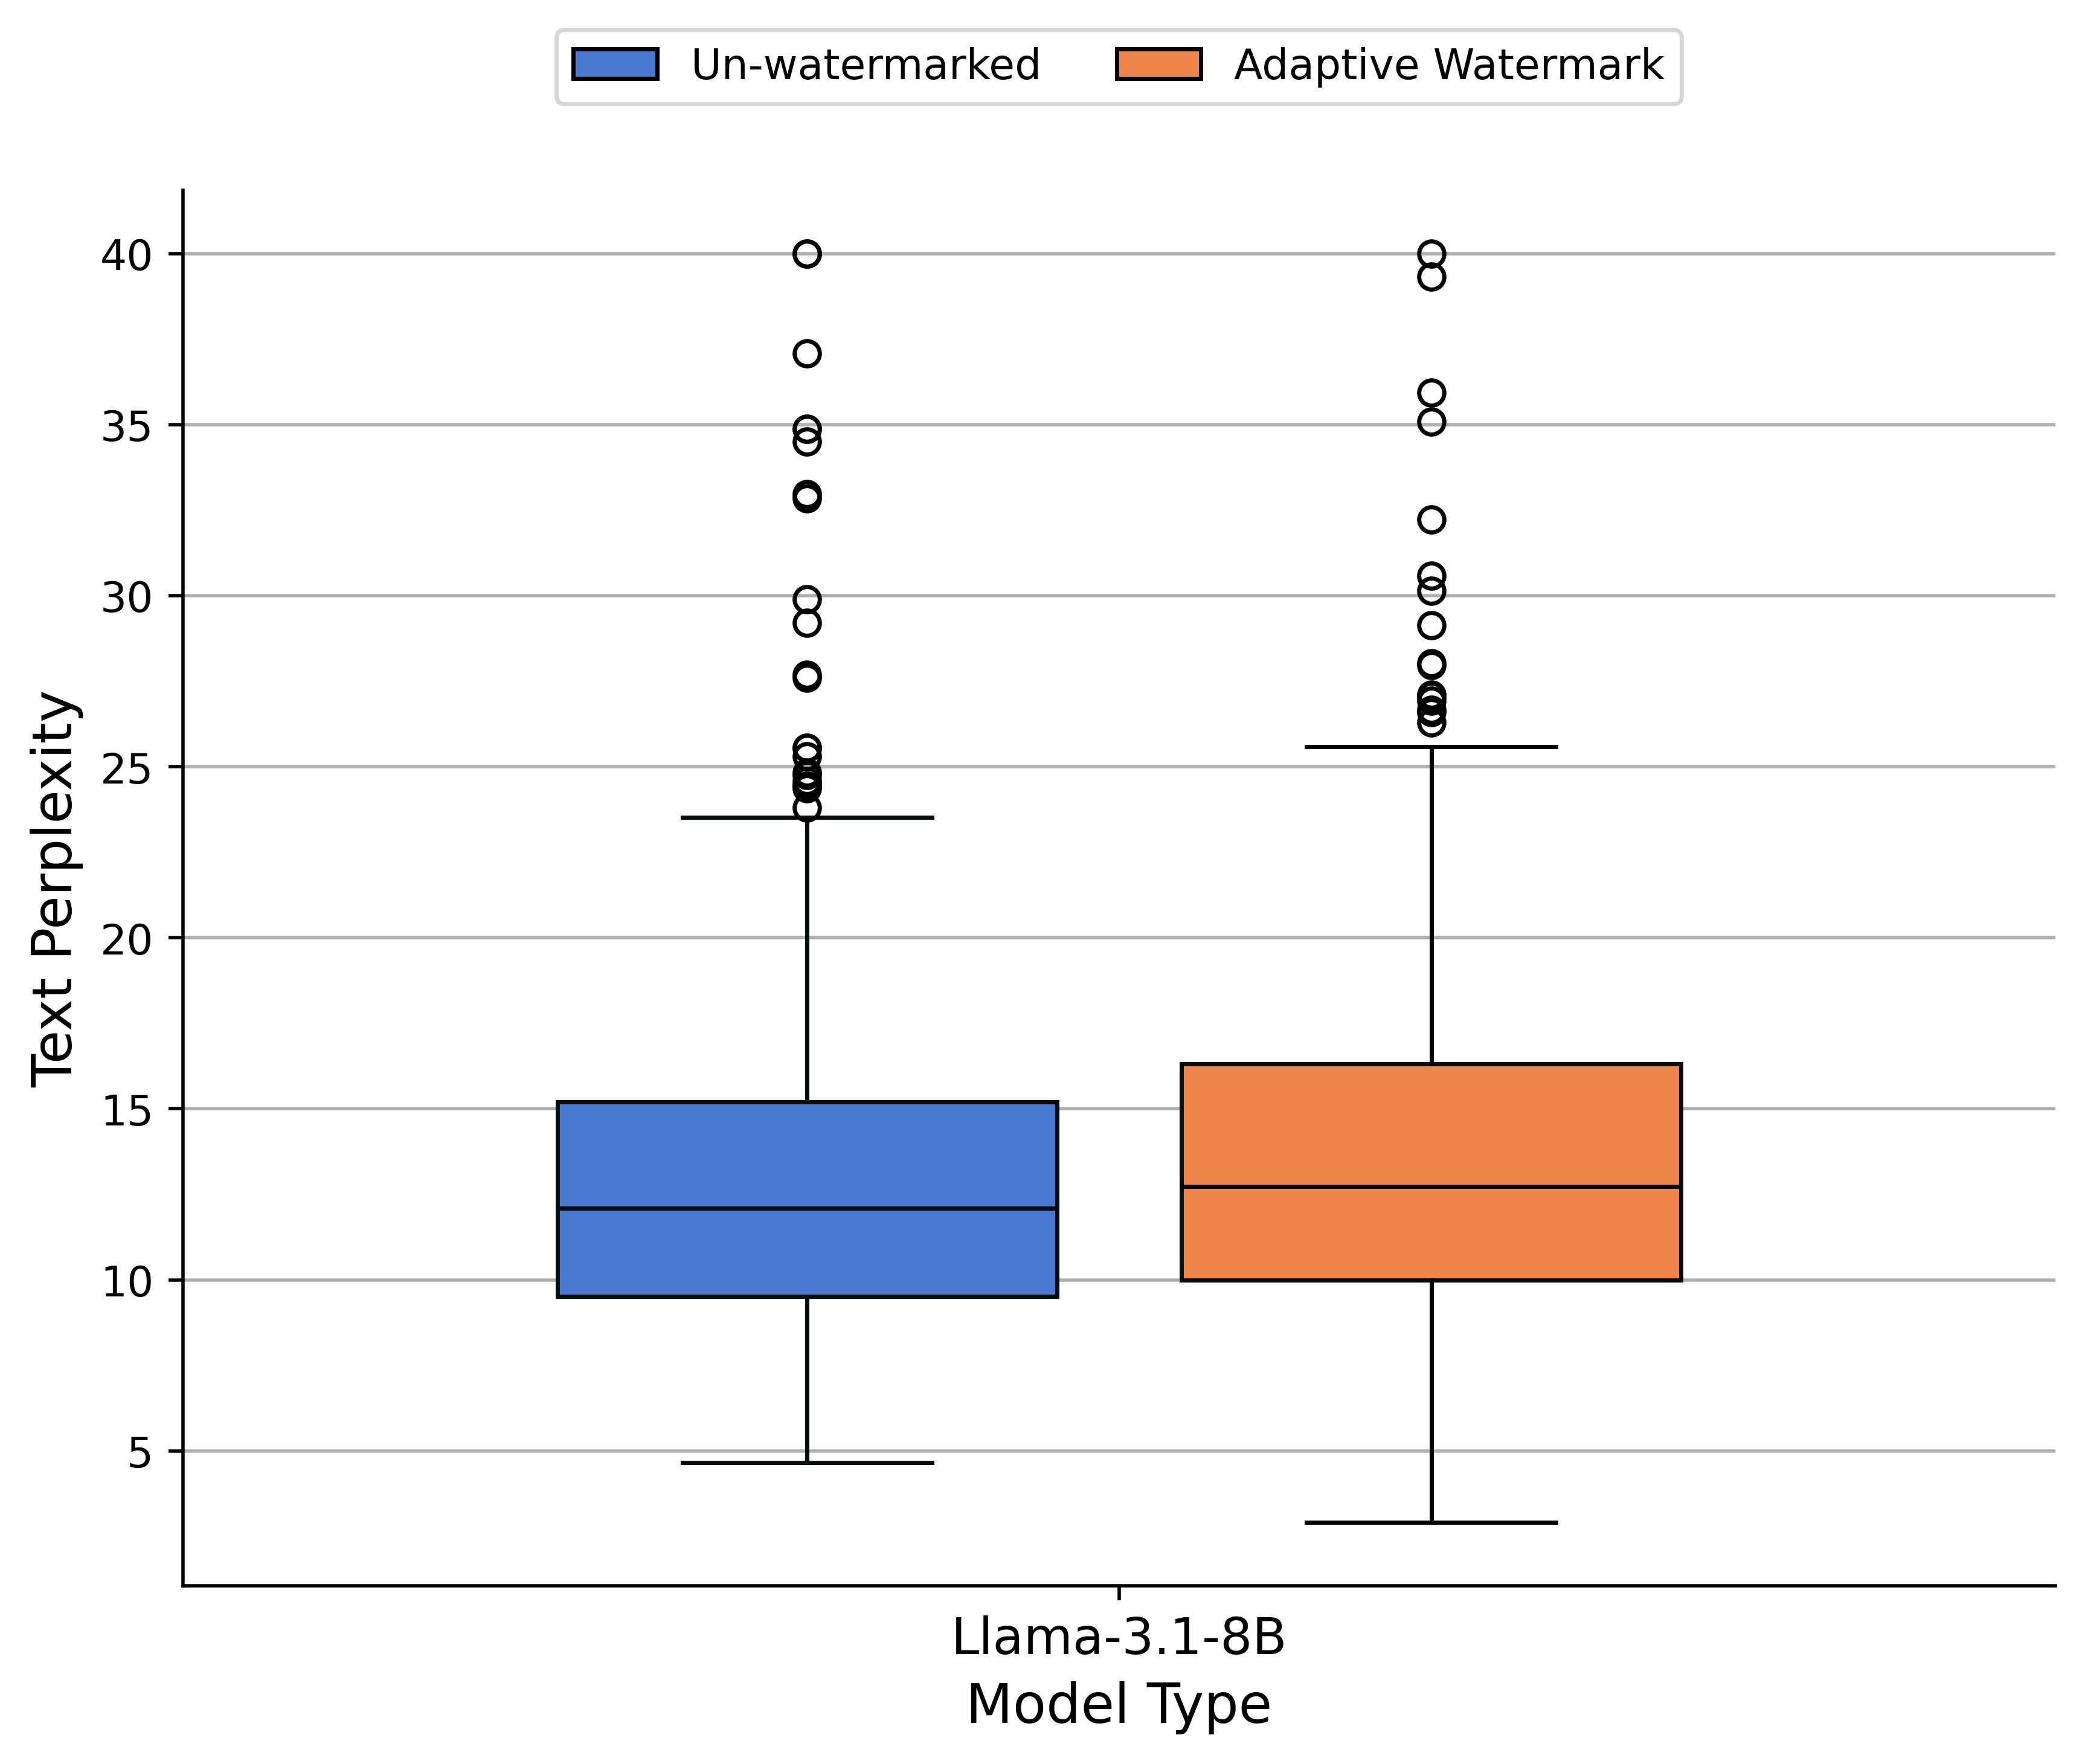

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


df= pd.read_csv('/home/yepeng.liu/projects/semantic_shield/adaptive-text-watermark/outputs/pplx_7b.csv')


pplx = [df['unwm_pplx'].tolist(), df['wm_pplx'].tolist()]

pplx = [[40.0 if i > 40 else i for i in j] for j in pplx]
data = pplx

# Colors for each group
colors = [u'#4878d0']  # Color for Group 1
shared_colors = [u'#ee854a', u'#6acc64', u'#956cb4', u'#8c613c', u'#d5bb67']  # Colors for corresponding boxes in G2, G3, and G4
colors += shared_colors * 3  # Repeat the shared colors for each box in Groups 2, 3, and 4

# Adjusting the positions to reduce the space between the groups
positions_group1 = [2, 2.5]
# Combining all positions
positions = positions_group1

plt.figure(figsize=(8, 6), dpi=500)
# plt.rc('font', family='monospace')
boxplots = plt.boxplot(data, positions=positions, patch_artist=True, widths=0.4)

# Applying the color scheme to each box
for box, whisker, cap, median, color in zip(boxplots['boxes'], boxplots['whiskers'], boxplots['caps'], boxplots['medians'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('#070d0d')
    box.set_linewidth(1)
    median.set_color('#070d0d')

    whisker.set_color('#070d0d')
    whisker.set_linewidth(1)

    cap.set_color('#070d0d')
    cap.set_linewidth(1)


# plt.title('Grouped Box Plot with Reduced Space Between Groups')
plt.xlabel('Model Type', fontsize=13)
plt.ylabel('Text Perplexity', fontsize=13)

# Custom x-ticks for group labels
plt.xticks([2.25], ['Llama-3.1-8B'], fontsize=12)
plt.grid(axis='y') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Creating custom legends
legend_element1 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#4878d0', edgecolor='black', linewidth=1, label='Un-watermarked')]
legend_element2 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#ee854a', edgecolor='black', linewidth=1, label='Adaptive Watermark')]


legend_elements = legend_element1 + legend_element2

labels = ['Un-watermarked', 'Adaptive Watermark']

plt.legend(legend_elements, labels[0:7], loc="upper center",\
               bbox_to_anchor=(0.5, 1.13), ncol=3, columnspacing=1.8,\
                handletextpad=0.8, fontsize=10)

plt.show()
# save the plot
# plt.savefig('WfK7_r2_3.png', bbox_inches='tight')

In [7]:
import pandas as pd
from tqdm import tqdm

# model: 'gpt-4-1106-preview'; 'gpt-3.5-turbo-instruct'

key = ""
scorer = OpenAI(api_key=key, model="davinci-002")


sweet_df = pd.read_csv("/home/UFAD/yepeng.liu/llm_watermark/watermark/idea2/rebuttal/sweet_opt67_delta2_gamma50_pe11_alpha1.csv")[:130]
sir_df = pd.read_csv("some_results/adap_seman_opt67_delta3_alpha2_pe11_k50_ab2-2.csv")[:130]
adatpive_df = pd.read_csv("opt67nm/adap_seman_opt67_delta3_alpha2_pe11_k50_fixgreen05_newmapping_dipper.csv")[:130]


sweet_sir_df = pd.DataFrame(columns=['adaptive_pplx','sweet_pplx', 'sir_pplx'])
for adaptive, sweet, sir in zip(adatpive_df['adaptive_watermark'], sweet_df['adaptive_watermark'], sir_df['adaptive_watermark']):
    adaptive_pplx = scorer.get_perplexity(adaptive)
    sweet_pplx = scorer.get_perplexity(sweet)
    sir_pplx = scorer.get_perplexity(sir)
    data = {'adaptive_pplx': [adaptive_pplx], 'sweet_pplx': [sweet_pplx], 'sir_pplx': [sir_pplx]}
    sweet_sir_df = pd.concat([sweet_sir_df, pd.DataFrame(data)], ignore_index=True)
    sweet_sir_df.to_csv('rebuttal/sweet_sir_df.csv', index=False)



/tmp/ipykernel_1387292/841901958.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sweet_sir_df = pd.concat([sweet_sir_df, pd.DataFrame(data)], ignore_index=True)


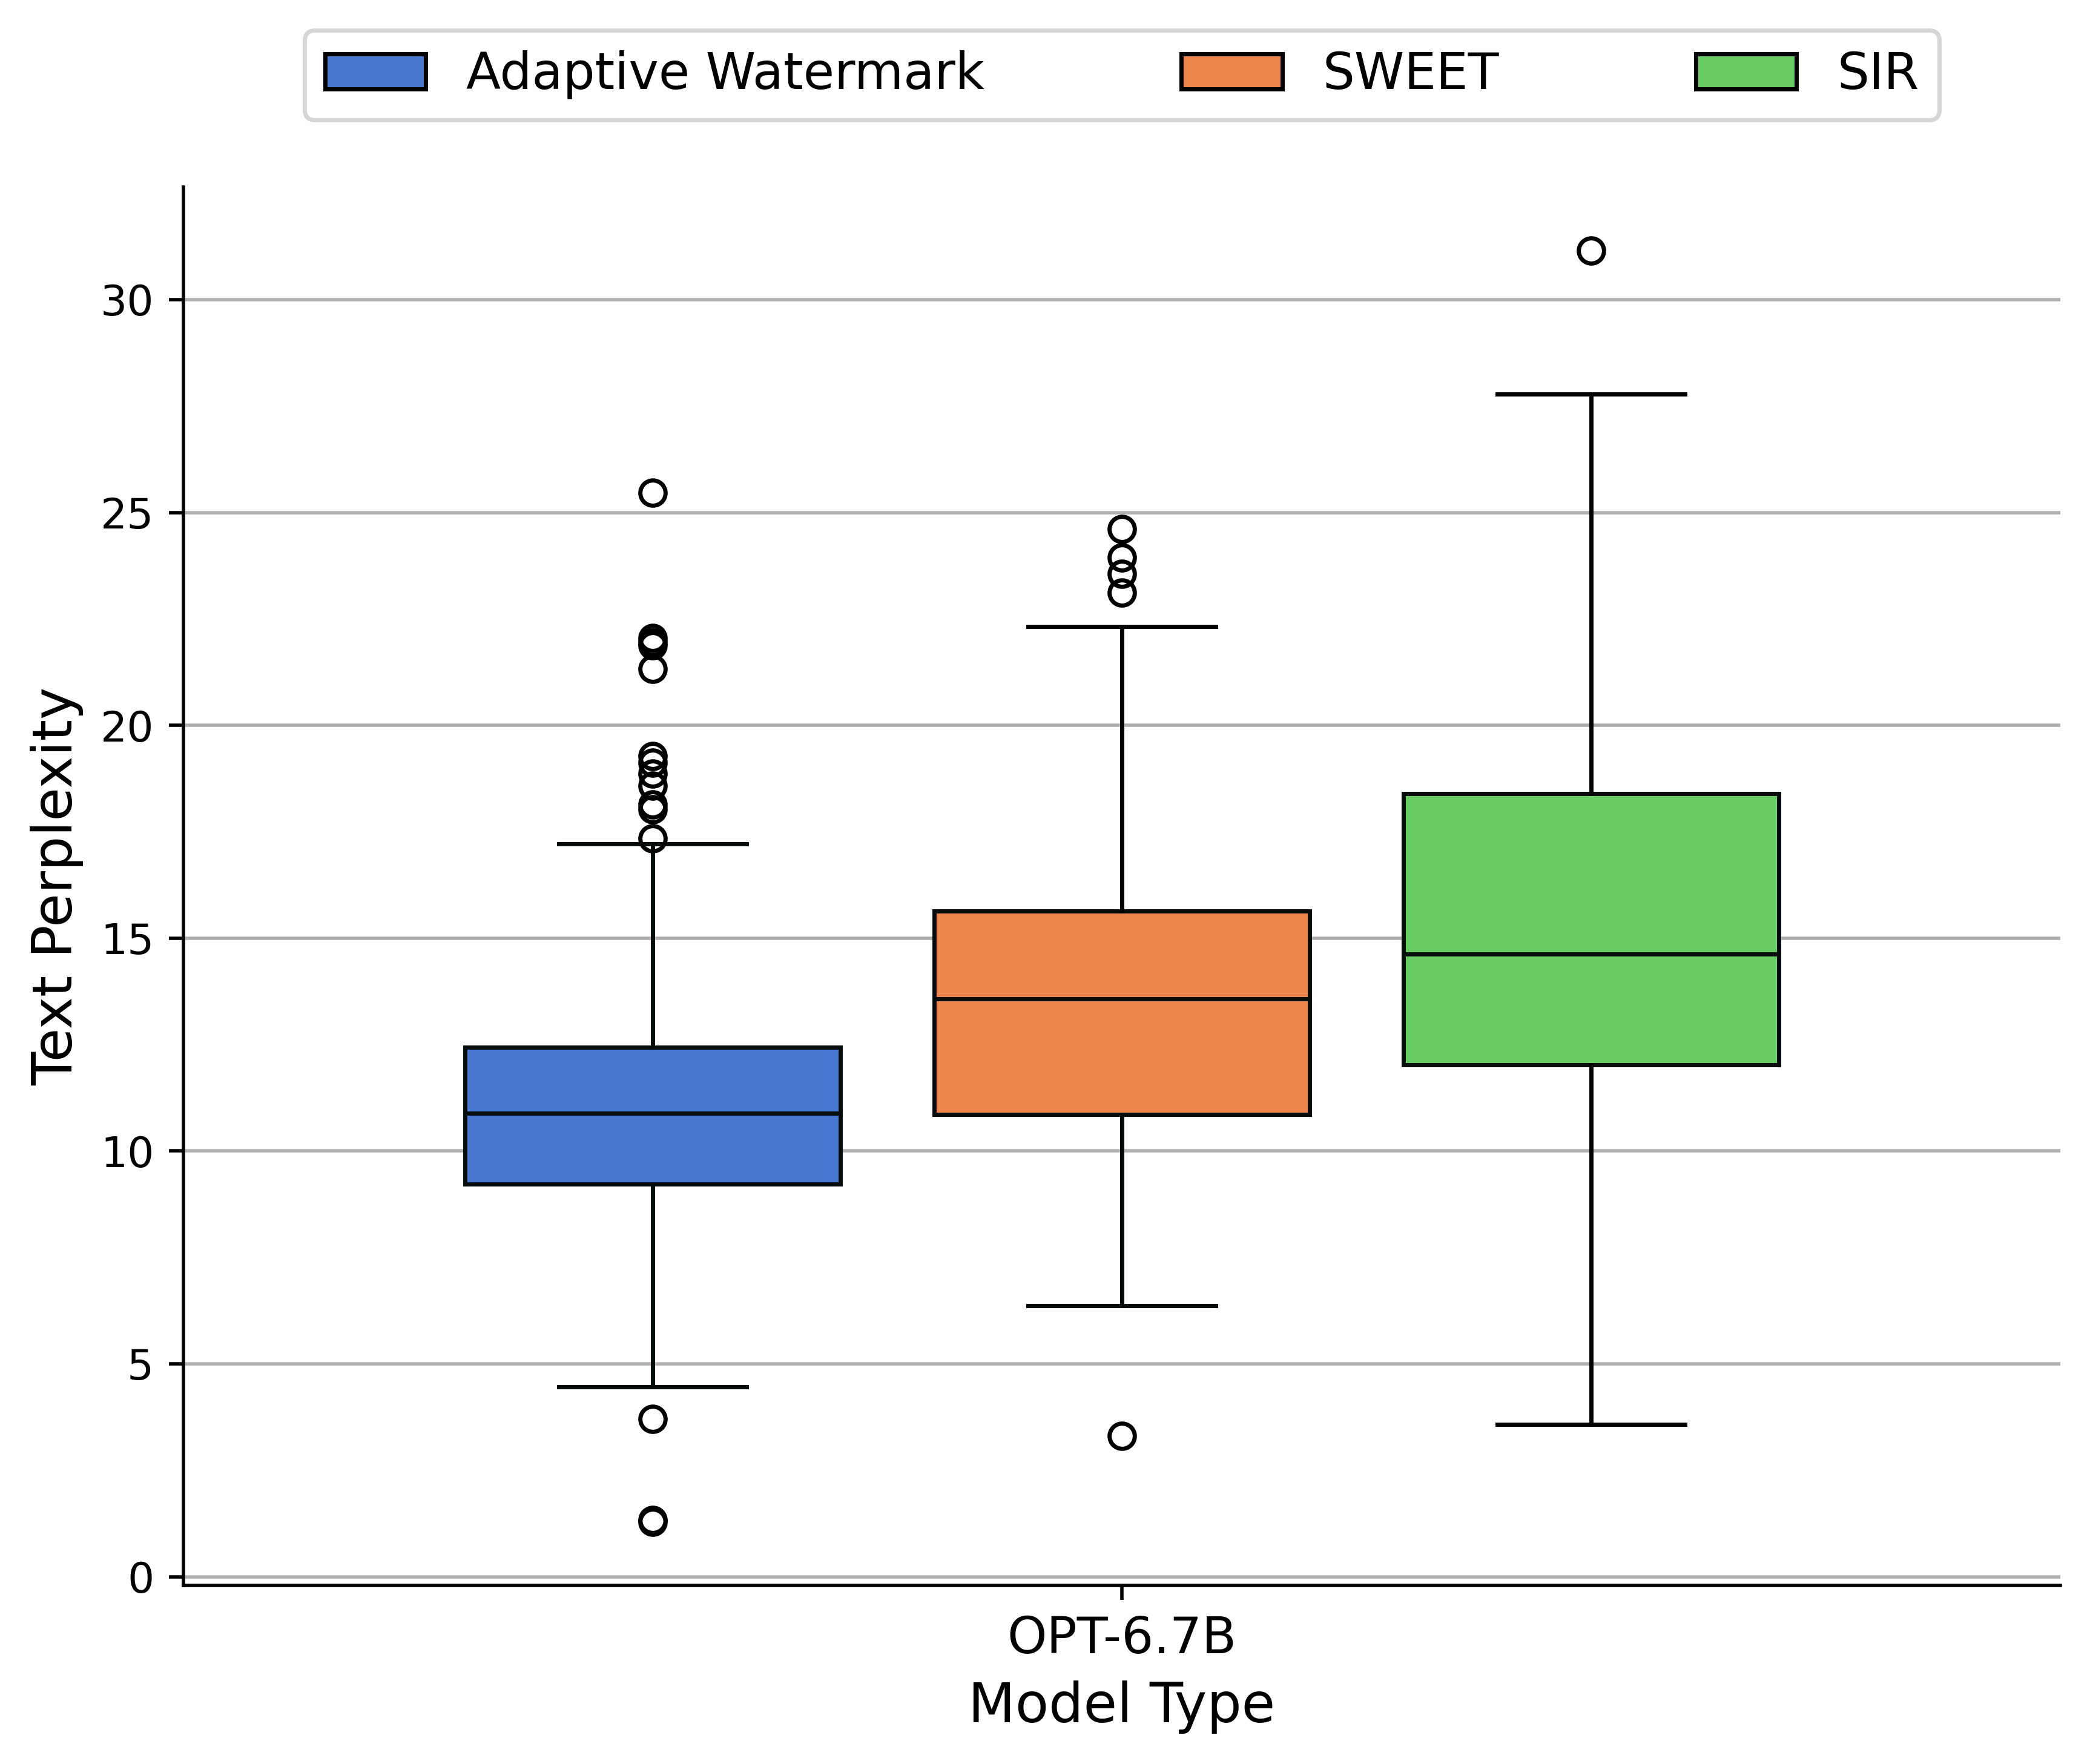

In [2]:
import matplotlib.pyplot as plt
import pandas as pd


df= pd.read_csv('rebuttal/sweet_sir_df.csv')[:400]
df2 = pd.read_csv('rebuttal/perplexity_opt67_all.csv')[:400]


opt67 = [df2['adaptive_watermark_pplx'].to_list(), df['sweet_pplx'].to_list(), df['sir_pplx'].to_list()]

# opt67 = [[50.0 if i > 50 else i for i in j] for j in opt67]
data = opt67

# Colors for each group
colors = [u'#4878d0']  # Color for Group 1
shared_colors = [u'#ee854a', u'#6acc64', u'#d65f5f', u'#956cb4', u'#8c613c', u'#d5bb67']  # Colors for corresponding boxes in G2, G3, and G4
colors += shared_colors * 3  # Repeat the shared colors for each box in Groups 2, 3, and 4

# Adjusting the positions to reduce the space between the groups
positions_group1 = [2, 2.5, 3]
# Combining all positions
positions = positions_group1

plt.figure(figsize=(8, 6), dpi=500)
# plt.rc('font', family='monospace')
boxplots = plt.boxplot(data, positions=positions, patch_artist=True, widths=0.4)

# Applying the color scheme to each box
for box, whisker, cap, median, color in zip(boxplots['boxes'], boxplots['whiskers'], boxplots['caps'], boxplots['medians'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('#070d0d')
    box.set_linewidth(1)
    median.set_color('#070d0d')

    whisker.set_color('#070d0d')
    whisker.set_linewidth(1)

    cap.set_color('#070d0d')
    cap.set_linewidth(1)


# plt.title('Grouped Box Plot with Reduced Space Between Groups')
plt.xlabel('Model Type', fontsize=13)
plt.ylabel('Text Perplexity', fontsize=13)

# Custom x-ticks for group labels
plt.xticks([2.5], ['OPT-6.7B'], fontsize=12)
plt.grid(axis='y') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Creating custom legends
# legend_element1 = [plt.Line2D([0], [0], color='#4878d0', lw=5, label='Human')]
legend_element1 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#4878d0', edgecolor='black', linewidth=1, label='Human')]
legend_element2 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#ee854a', edgecolor='black', linewidth=1, label='Un-watermarked')]
legend_element3 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#6acc64', edgecolor='black', linewidth=1, label='Adaptive Watermark')]
# legend_element4 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#d65f5f', edgecolor='black', linewidth=1, label='EXP-edit Watermark')]
# legend_element5 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#956cb4', edgecolor='black', linewidth=1, label='KGW-0 Watermark')]
# legend_element6 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#8c613c', edgecolor='black', linewidth=1, label='KGW-1 Watermark')]
# legend_element7 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#d5bb67', edgecolor='black', linewidth=1, label='KGW-2 Watermark')]

legend_elements = legend_element1 + legend_element2 + legend_element3 

labels = ['Adaptive Watermark', 'SWEET', 'SIR']

plt.legend(legend_elements, labels[0:7], loc="upper center",\
               bbox_to_anchor=(0.5, 1.13), ncol=3, columnspacing=3.9,\
                handletextpad=0.8, fontsize=12)

# plt.show()
plt.savefig('rebuttal/WfK7_q2.png', bbox_inches='tight')

##### Mistral

In [8]:
import pandas as pd
from tqdm import tqdm

# model: 'gpt-4-1106-preview'; 'gpt-3.5-turbo-instruct'

key = ""
scorer = OpenAI(api_key=key, model="davinci-002")

df = pd.read_csv('rebuttal/adap_seman_mistral_delta2_alpha2_pe11_k50_fixgreen05_newmapping.csv')[:400]
green_df = pd.read_csv('rebuttal/green_watermarked_mistral_delta2_gamma50_pe11_k50.csv')[:400]
unwatermarked_df = pd.read_csv('rebuttal/unwatermarked_mistral_pe11_k50.csv')[:400]

mistral_df = pd.DataFrame(columns=['unwatermarked_pplx','adaptive_pplx', 'green_pplx'])
for unwatermarked, adaptive, green in zip(unwatermarked_df['unwatermarked'], df['adaptive_watermark'], green_df['green_watermarked']):
    unwatermarked_pplx = scorer.get_perplexity(unwatermarked)
    adaptive_pplx = scorer.get_perplexity(adaptive)
    green_pplx = scorer.get_perplexity(green)
    data = {'unwatermarked_pplx': [unwatermarked_pplx],'adaptive_pplx': [adaptive_pplx], 'green_pplx': [green_pplx]}
    mistral_df = pd.concat([mistral_df, pd.DataFrame(data)], ignore_index=True)
    mistral_df.to_csv('rebuttal/mistral_df.csv', index=False)


/tmp/ipykernel_1046029/2303977997.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mistral_df = pd.concat([mistral_df, pd.DataFrame(data)], ignore_index=True)


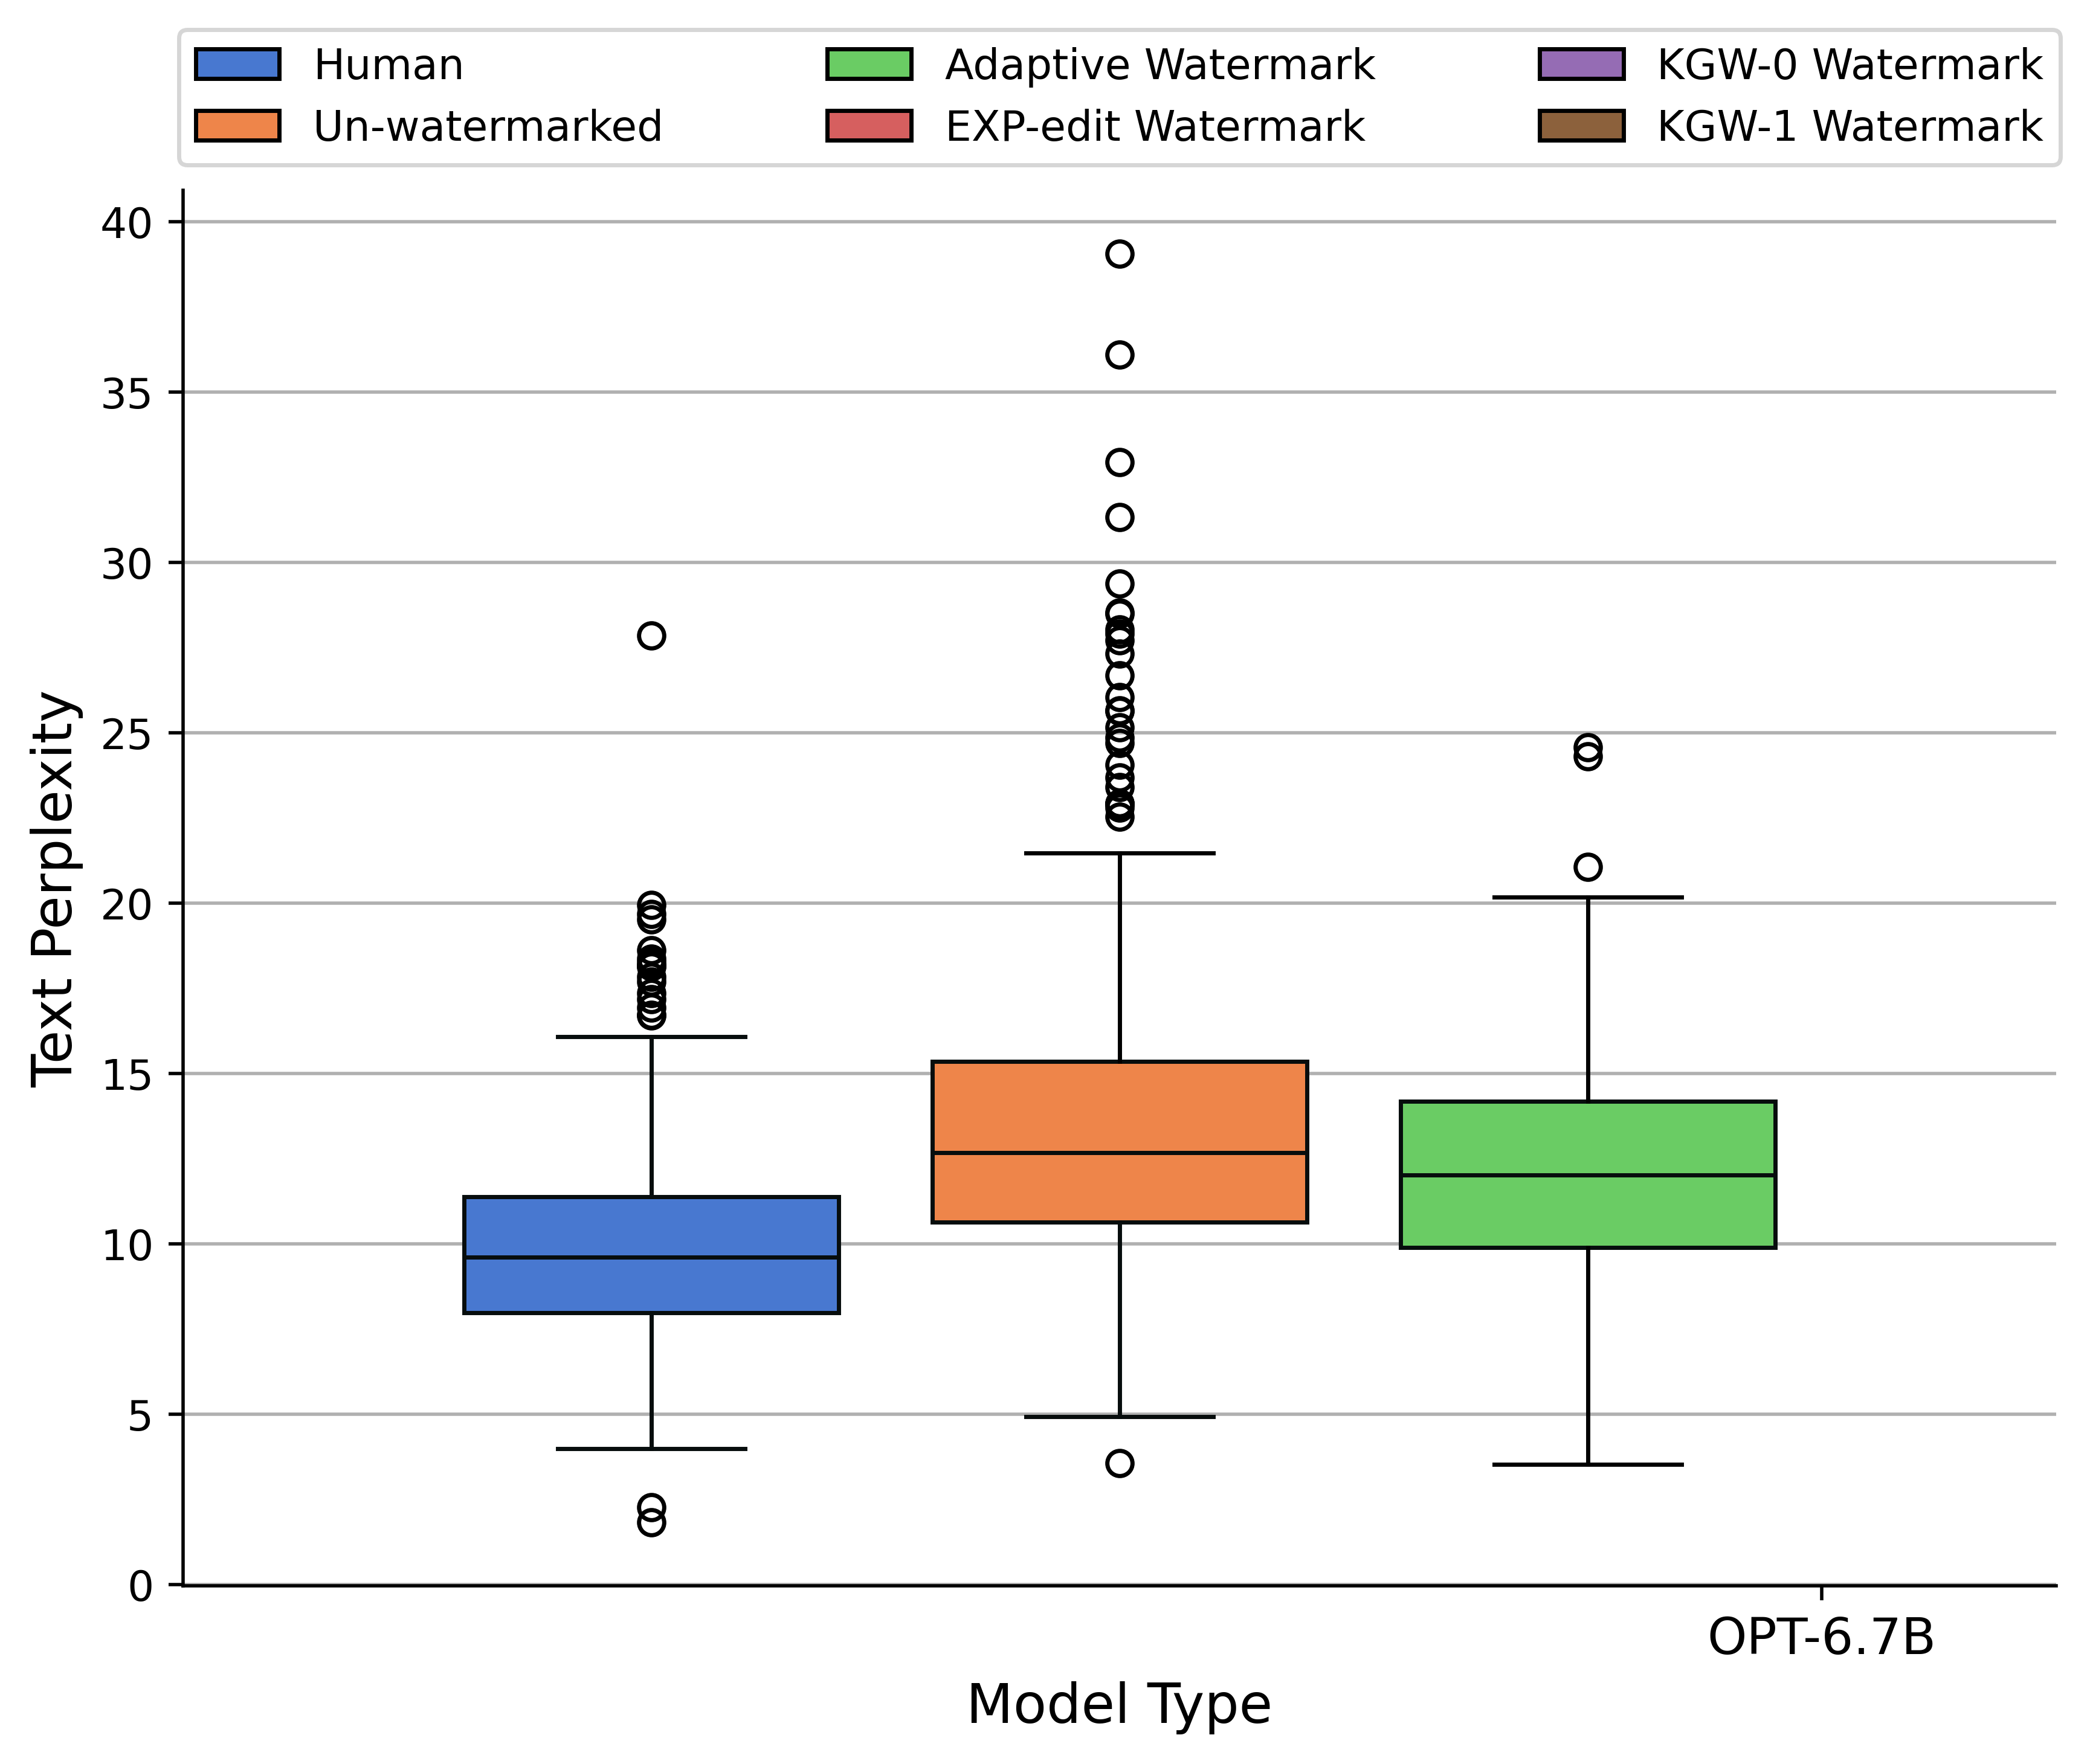

In [17]:
import matplotlib.pyplot as plt
import pandas as pd


df= pd.read_csv('rebuttal/mistral_df.csv')[:400]


opt67 = [df['unwatermarked_pplx'].to_list(), df['adaptive_pplx'].to_list(), df['green_pplx'].to_list()]

opt67 = [[50.0 if i > 50 else i for i in j] for j in opt67]
data = opt67

# Colors for each group
colors = [u'#4878d0']  # Color for Group 1
shared_colors = [u'#ee854a', u'#6acc64', u'#d65f5f', u'#956cb4', u'#8c613c', u'#d5bb67']  # Colors for corresponding boxes in G2, G3, and G4
colors += shared_colors * 3  # Repeat the shared colors for each box in Groups 2, 3, and 4

# Adjusting the positions to reduce the space between the groups
positions_group1 = [2, 2.5, 3]
# Combining all positions
positions = positions_group1

plt.figure(figsize=(8, 6), dpi=500)
# plt.rc('font', family='monospace')
boxplots = plt.boxplot(data, positions=positions, patch_artist=True, widths=0.4)

# Applying the color scheme to each box
for box, whisker, cap, median, color in zip(boxplots['boxes'], boxplots['whiskers'], boxplots['caps'], boxplots['medians'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('#070d0d')
    box.set_linewidth(1)
    median.set_color('#070d0d')

    whisker.set_color('#070d0d')
    whisker.set_linewidth(1)

    cap.set_color('#070d0d')
    cap.set_linewidth(1)


# plt.title('Grouped Box Plot with Reduced Space Between Groups')
plt.xlabel('Model Type', fontsize=13)
plt.ylabel('Text Perplexity', fontsize=13)

# Custom x-ticks for group labels
plt.xticks([3.25], ['OPT-6.7B'], fontsize=12)
plt.grid(axis='y') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Creating custom legends
# legend_element1 = [plt.Line2D([0], [0], color='#4878d0', lw=5, label='Human')]
legend_element1 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#4878d0', edgecolor='black', linewidth=1, label='Human')]
legend_element2 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#ee854a', edgecolor='black', linewidth=1, label='Un-watermarked')]
legend_element3 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#6acc64', edgecolor='black', linewidth=1, label='Adaptive Watermark')]
legend_element4 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#d65f5f', edgecolor='black', linewidth=1, label='EXP-edit Watermark')]
legend_element5 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#956cb4', edgecolor='black', linewidth=1, label='KGW-0 Watermark')]
legend_element6 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#8c613c', edgecolor='black', linewidth=1, label='KGW-1 Watermark')]
# legend_element7 = [plt.Rectangle((0.5, 0), 1, 0.5, facecolor='#d5bb67', edgecolor='black', linewidth=1, label='KGW-2 Watermark')]

legend_elements = legend_element1 + legend_element2 + legend_element3 + legend_element4 + legend_element5 + legend_element6

labels = ['Human', 'Un-watermarked', 'Adaptive Watermark', 'EXP-edit Watermark', 'KGW-0 Watermark', 'KGW-1 Watermark']

plt.legend(legend_elements, labels[0:7], loc="upper center",\
               bbox_to_anchor=(0.5, 1.13), ncol=3, columnspacing=3.9,\
                handletextpad=0.8, fontsize=10)

plt.show()